In [14]:
import os
import pandas as pd

def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    data = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return data

def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    data = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return data

train = train_df('cleaned/Training')
test = test_df('cleaned/Testing')

In [4]:
from sklearn.model_selection import train_test_split
valid, test = train_test_split(test, train_size=0.5, random_state=20, stratify=test['Class'])

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale=1/255)
testing = generator.flow_from_dataframe(test, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=(256, 256), shuffle=False)

training = generator.flow_from_dataframe(train, x_col='Class Path',
                                  y_col='Class', batch_size=32,
                                  target_size=(256, 256))

validation = generator.flow_from_dataframe(valid, x_col='Class Path',
                                     y_col='Class', batch_size=32,
                                     target_size=(256, 256))

Found 1311 validated image filenames belonging to 4 classes.
Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


In [5]:
import tensorflow as tf
model = tf.keras.models.load_model("../Models/mri-brain-tumor-detector.keras")

In [20]:
import numpy as np

preds = model.predict(testing)
y_pred = np.argmax(preds, axis=1)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 78s 950ms/step


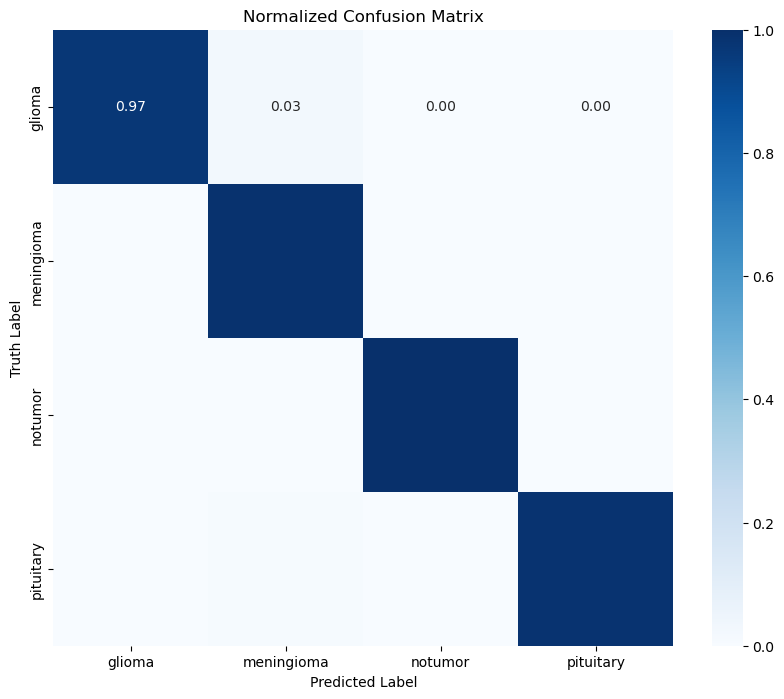

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_dict = training.class_indices

# Compute the confusion matrix
cm = confusion_matrix(testing.classes, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.title('Normalized Confusion Matrix')
plt.show()


In [22]:
from sklearn.metrics import classification_report

clr = classification_report(testing.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       300
           1       0.96      0.99      0.98       306
           2       1.00      1.00      1.00       405
           3       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311

